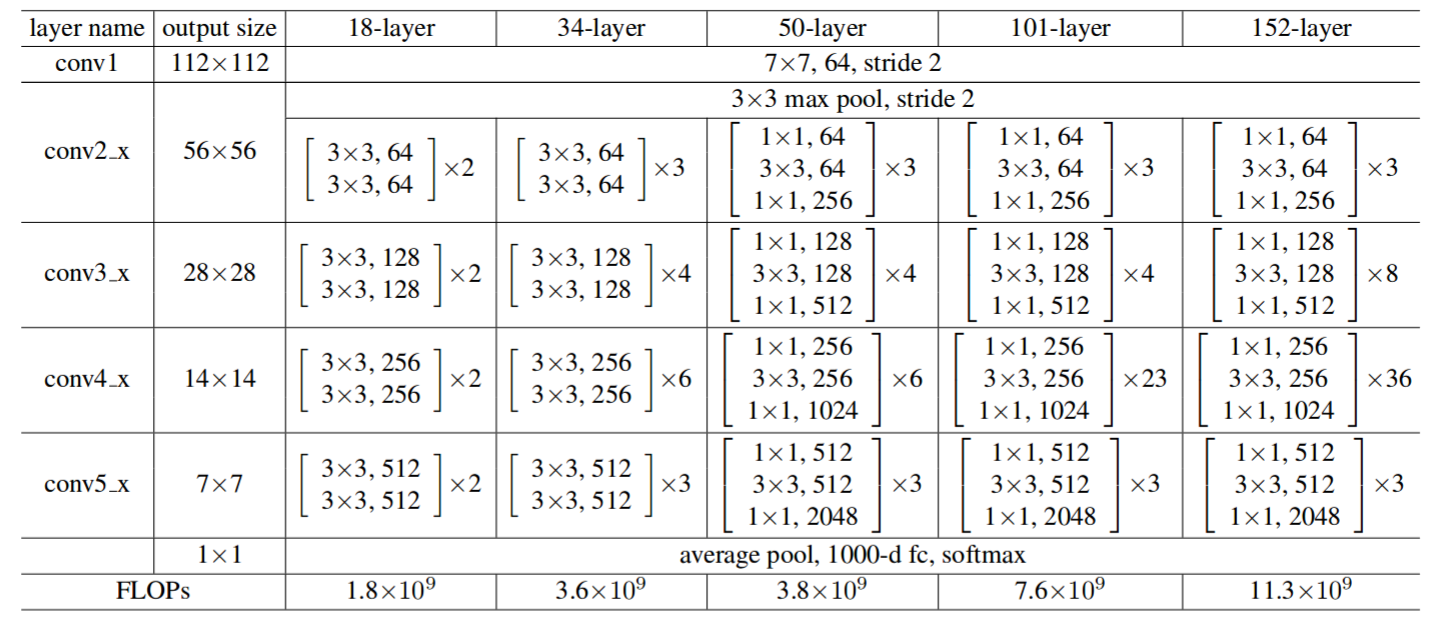

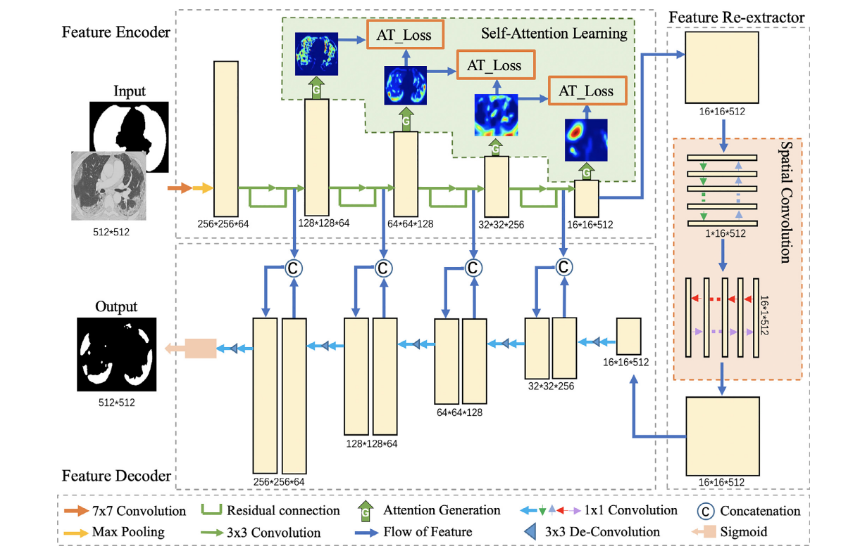

In [ ]:
import tensorflow as tf
from keras.layers import Layer
from keras import layers

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.activations import relu
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Input, Conv2DTranspose
from tensorflow.keras import Model
from tensorflow.keras import layers as Layers

import numpy as np


In [ ]:
class ResBlock(Model):
    """
    This is ResNet block that we utelized it to build ResNet_34 (backbone of SSA_Net).
    Arguments:
            channels -- Number of image channels.
            stride -- Stride of convolution 2D
    """
    def __init__(self, channels, stride=1):
        super(ResBlock, self).__init__()
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()


        
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


In [ ]:
#######################################
# up_conv1= layers.Concatenate(axis=3)([up_conv1, p4])
#########################
class UpConvBlock(Layer):
    """
    This block of code contaiins deconvolution. We created feature decoder with 
    this.
    Arguments:
            num_filter -- Number of filters that will use in convolution 2D.
    """

    def __init__(self, num_filter = 512, **kwargs):
        super(UpConvBlock, self).__init__()
        self.up_conv1_1 = Conv2D(num_filter, (1,1), padding = 'same')
        self.de_conv1= layers.Conv2DTranspose(num_filter, (3,3),(2,2), padding='same')
        self.up_conv1_2 = layers.Conv2D(int(num_filter/2), (1,1), padding = 'same')


    def call(self, x):
        x = self.up_conv1_1(x)
        x = self.de_conv1(x)
        x = self.up_conv1_2(x)
        
        return x

In [ ]:

class AttentionLayer(Layer):
    """
        This uses for attention part that show which part of the image gets focused.
        Arguments:
            input_shape -- Shape of input

    """

    def __init__(self, input_shape, **kwargs):
        super(AttentionLayer, self).__init__()
        # self.input_shape = input_shape
        self.upsampling = layers.UpSampling2D(interpolation="bilinear")
        self.softmax = tf.nn.softmax
        self.Input = Input(input_shape)


    def attention_generator(self, tnsr):
        """
        This is a Attention Generator Block

        Arguments:
            arr -- This is a input Tensor
        Returns:
            arr --  Output Tensor that claculated
        """
        tnsr = tf.math.abs(tnsr)
        tnsr = tf.math.pow(tnsr, 2)
        tnsr = tf.math.reduce_sum(tnsr, axis = 3)
        tnsr = tf.expand_dims(tnsr, axis = -1)
        return tnsr


    def call(self, x, training=True):
        # x = self.Input(x)
        x = self.attention_generator(x)
        x = self.upsampling(x, training=training)
        x = self.softmax(x)
        return x



In [ ]:


class SpatialConv(Layer):
    """
    This is spatial convolution part. This part contains four parts:
            1 - top to down
            2 - down to top
            3 - rihit to left
            4 - left to right

    Arguments:
            input_shape -- Shape of input
            out_dim -- output channels
    
    """

    def __init__(self, in_shape, out_dim):
        super(SpatialConv, self).__init__()
        # filters == > output dimention
        self.input_layer = Input(in_shape)
        self.conv1 = Conv2D(filters=1, kernel_size=(1, 9), padding="same")
        self.relu = ReLU()
        self.conv2 = Conv2D(filters=out_dim, kernel_size=(1, 9), padding="same")

    def sconv(self, x):
        # top to down ##########################################################
        # self.input_layer
        feature_list_old = []
        feature_list_new = []
        tf.compat.v1.enable_eager_execution()
        for chan in range(x.shape[1]):
            # Shape of x is (64, 64, 512)
            feature_list_old.append(tf.expand_dims(x[:, chan, :, :], axis=1))

        feature_list_new.append(tf.expand_dims(x[:, 0, :, :], axis=1))
        top2down = self.conv1(feature_list_old[0])
        top2down = self.relu(top2down)
        top2down = tf.add(top2down, tf.convert_to_tensor(feature_list_old[1], dtype=tf.float32))
        feature_list_new.append(top2down)
        for chan in range(2, x.shape[1]):
            top2down = self.relu(self.conv1(tf.convert_to_tensor(feature_list_old[chan-1], dtype=tf.float32)))
            top2down = tf.add(tf.convert_to_tensor(feature_list_old[chan], dtype=tf.float32), top2down)
            feature_list_new.append(top2down)
        

        # down to top ##########################################################

        feature_list_old = feature_list_new
        feature_list_new = []
        num_features = len(feature_list_old) - 1

        feature_list_new.append(feature_list_old[num_features])
        down2top = tf.add(self.relu(self.conv1(feature_list_old[num_features])), feature_list_old[num_features-1])
        feature_list_new.append(down2top)

        for chan in range(2, x.shape[1]):
            down2top = self.relu(self.conv1(feature_list_old[num_features - chan]))
            down2top = tf.add(down2top, feature_list_old[num_features - chan - 1])
            # try:
            #     down2top = tf.add(down2top, feature_list_old[num_features - chan - 1])
            # except:
            #     down2top = tf.add(down2top, tf.convert_to_tensor(feature_list_old[num_features - chan - 1], dtype=tf.float32))
            feature_list_new.append(down2top)

        feature_list_new.reverse()
        processed_features = tf.concat(feature_list_new, axis=1)
        # processed_features = tf.squeeze(processed_features)

        # # left to right ########################################################

        feature_list_old = []
        feature_list_new = []


        for chan in range(x.shape[2]): # processed_features
            # Shape of x is (64, 64, 512)
            feature_list_old.append(tf.expand_dims(processed_features[:, :, chan, :], axis=2))

        feature_list_new.append(tf.expand_dims(processed_features[:, :, 0, :], axis=2))
        # left2right = self.conv2(tf.convert_to_tensor(feature_list_old[0], dtype=tf.float32))
        left2right = self.conv2(feature_list_old[0])

        left2right = self.relu(left2right)
        left2right = tf.add(left2right, feature_list_old[1])
        # left2right = tf.add(left2right, tf.convert_to_tensor(feature_list_old[1], dtype=tf.float32))

        feature_list_new.append(left2right)
        for chan in range(2, x.shape[2]): # processed_features
            # left2right = self.relu(self.conv2(tf.convert_to_tensor(feature_list_old[chan-1], dtype=tf.float32)))
            left2right = self.relu(self.conv2(feature_list_old[chan-1]))

            # left2right = tf.add(tf.convert_to_tensor(feature_list_old[chan], dtype=tf.float32), left2right)
            left2right = tf.add(feature_list_old[chan], left2right)

            feature_list_new.append(left2right)

        # right to left ########################################################

        feature_list_old = feature_list_new
        feature_list_new = []
        num_features = len(feature_list_old) - 1

        feature_list_new.append(feature_list_old[num_features])
        right2left = tf.add(self.relu(self.conv2(feature_list_old[num_features])), feature_list_old[num_features-1])
        feature_list_new.append(right2left)
        

        for chan in range(2, processed_features.shape[2]):
            right2left = self.relu(self.conv2(feature_list_old[num_features - chan]))
            right2left = tf.add(right2left, feature_list_old[num_features - chan - 1])
            # try:
            #     right2left = tf.add(right2left, feature_list_old[num_features - chan - 1])
            # except:
            #     down2top = tf.add(right2left, tf.convert_to_tensor(feature_list_old[num_features - chan - 1], dtype=tf.float32))
            feature_list_new.append(right2left)

        # Here we implement some process to return output of this layer.
        # print(len(feature_list_new))
        feature_list_new.reverse()
        # print(len(feature_list_new))
        # print(processed_features.shape)
        processed_features = tf.concat(feature_list_new, axis=2)
        # print(processed_features.shape)
        # processed_features = tf.squeeze(processed_features)

        return processed_features

    def call(self, x):
        output = self.sconv(x)
        return output

        # def summary_model(self):
        #     inputs = keras.Input(shape=(512, 512, 3))
        #     outputs = self.call(inputs)
        #     keras.Model(inputs=inputs, outputs=outputs).summary()
 

In [ ]:

class SSA_Net(Model):
    """
    The main model. SSA_Net contains Three parts.
            1 - Feature Encoder: This contains two parts. First, ResNet_34 uses for 
                backbone of the Feature Encoder. Second, Self_Attention Learning 
                shows where  model is focused and use it to teaches model that 
                focused on important parts.

            2 - Feature Re-extracter: This part uses spatial convolution to extract
                important parts of our data

            3 - Feature Decoder: This is designed for constructing the segmentation
                results from feature encoder and feature extractor. 

    """

    def __init__(self):
        super(SSA_Net, self).__init__(name='SSA_Net')
        # Feature Encoder
        self.conv1 = Conv2D(64, 7, padding='same')
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.mp1 = MaxPooling2D()

        self.attention_block1 = AttentionLayer((128,128,64))
        self.attention_block2 = AttentionLayer((64,64,128))
        self.attention_block3 = AttentionLayer((32,32,256))
        self.attention_block4 = AttentionLayer((16,16,512))

        self.conv2_1 = ResBlock(64,2)
        self.conv2_2 = ResBlock(64)
        self.conv2_3 = ResBlock(64)

        self.conv3_1 = ResBlock(128, 2)
        self.conv3_2 = ResBlock(128)
        self.conv3_3 = ResBlock(128)
        self.conv3_4 = ResBlock(128)

        self.conv4_1 = ResBlock(256, 2)
        self.conv4_2 = ResBlock(256)
        self.conv4_3 = ResBlock(256)
        self.conv4_4 = ResBlock(256)
        self.conv4_5 = ResBlock(256)
        self.conv4_6 = ResBlock(256)

        self.conv5_1 = ResBlock(512, 2)
        self.conv5_2 = ResBlock(512)
        self.conv5_3 = ResBlock(512)

        # Feature Re-extracter
        # Shape of input and output --> (64, 64, 512)
        self.spatial_conv = SpatialConv(in_shape=(None, 64, 64, 512), out_dim = 512)

        # Feature Decoder
        self.up_conv1 = UpConvBlock(num_filter = 512)
        self.up_conv2 = UpConvBlock(num_filter = 256)
        self.up_conv3 = UpConvBlock(num_filter = 128)
        self.up_conv4 = UpConvBlock(num_filter = 128)
        self.up_conv5 = UpConvBlock(num_filter = 6)


        # self.sigmoid = layers.Activation('sigmoid')
        self.softmax = layers.Softmax()

        

    def call(self, x):
        # Feature Encoder ######################################################
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        xc_0 = self.mp1(x)
        # shape -> 256 256 64
        # print(xc_0.shape)

        # x = self.conv2_1(x)
        x = self.conv2_1(xc_0)
        x = self.conv2_2(x)
        xc_1 = self.conv2_3(x)
        # shape -> print(xc_1.shape)
        # 128 128 64

        # x1 = self.attention_block(x)
        x1 = self.attention_block1(xc_1)

        # x = self.conv3_1(x)
        x = self.conv3_1(xc_1)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        xc_2 = self.conv3_4(x)
        # print(xc_2.shape)
        # shape -> 64 64 128

        # x2 = self.attention_block(x)
        x2 = self.attention_block2(xc_2)

        # x = self.conv4_1(x)
        x = self.conv4_1(xc_2)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.conv4_5(x)
        xc_3 = self.conv4_6(x)
        # print(xc_3.shape)
        # shape -> 32 32 256

        # x3 = self.attention_block(x)
        x3 = self.attention_block3(xc_3)
        
        # x = self.conv5_1(x)
        x = self.conv5_1(xc_3)
        x = self.conv5_2(x)
        xc_4 = self.conv5_3(x)
        # print(xc_4.shape)
        # shape -> 16 16 512

        x4 = self.attention_block4(xc_4)
        # Feature Re-extracter #################################################
        tf.compat.v1.enable_eager_execution()
        # spatial convolution
        # print(xc_4.shape)
        x_sc = self.spatial_conv(xc_4)
        # x_sc = xc_4

        # Feature Decoder ######################################################
        # we could use concatenate(axis = 3) instead of add layers
        x_up = self.up_conv1(x_sc)
        # print(x_up.shape)
        # shape -> 32 32 256
        x_up = layers.Add()([x_up, xc_3])

        x_up = self.up_conv2(x_up)
        # print(x_up.shape)
        # shape -> 64 64 128
        x_up = layers.Add()([x_up, xc_2])

        x_up = self.up_conv3(x_up)
        # print(x_up.shape)
        # shape -> 128 128 64
        x_up = layers.Add()([x_up, xc_1])

        x_up = self.up_conv4(x_up)
        # print(x_up.shape)
        # shape -> 256 256 32
        x_up = layers.Add()([x_up, xc_0])

        x_up = self.up_conv5(x_up)
        x_up = self.softmax(x_up)




        return x_up, x1, x2, x3, x4

    def summary_model(self):
        inputs = keras.Input(shape=(512, 512, 3))
        outputs = self.call(inputs)
        keras.Model(inputs=inputs, outputs=outputs).summary()

In [ ]:
if __name__ == "__main__":
    tf.compat.v1.enable_eager_execution()
    model = SSA_Net()
    model.summary_model()

16
16
(None, 16, 16, 512)
(None, 16, 16, 512)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_156 (InputLayer)         [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1225 (Conv2D)           (None, 512, 512, 64  9472        ['input_156[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_925 (Batch  (None, 512, 512, 64  256        ['conv2d_1225[0][0]']            
 Normalization)                 )             